In [39]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
import tensorflow as tf
import keras
import numpy as np

In [40]:
tf.test.is_built_with_cuda()

True

In [41]:
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

False

In [44]:
from keras.datasets import boston_housing

In [45]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [46]:
train_data.shape

(404, 13)

In [47]:
test_data.shape

(102, 13)

In [48]:
train_data[1]

array([2.1770e-02, 8.2500e+01, 2.0300e+00, 0.0000e+00, 4.1500e-01,
       7.6100e+00, 1.5700e+01, 6.2700e+00, 2.0000e+00, 3.4800e+02,
       1.4700e+01, 3.9538e+02, 3.1100e+00])

In [49]:
train_targets[:10]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

In [50]:
# let's preprocess the data, normalizing by the std and substracting the mean 
mean = train_data.mean(axis=0) 
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [14]:
# let's build the neural network
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', 
                          input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [15]:
# because we have so few data points, it's better to use k-fold validation
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

In [16]:
import time

In [17]:
start = time.perf_counter()
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], 
                                        train_data[(i+1) * num_val_samples:]], 
                                        axis=0)
    
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], 
                                        train_targets[(i+1) * num_val_samples:]], 
                                        axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, 
             epochs=num_epochs, batch_size=1, verbose=0)
    
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

    
elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
Elapsed 93.259 seconds.


with GPU: Elapsed 539.724 seconds.  
without GPU: Elapsed 93.259 seconds  
Much faster with CPU

In [18]:
all_scores

[1.9776426813389996, 2.203915544075541, 2.9454972909228636, 2.3299699343077025]

In [19]:
np.mean(all_scores)

2.3642563626612763

This score says we are off by ~`$2.4k`, with prices that range from `$10k` to `$50k`.

Let's train with more epochs, keeping track of how well the model does.

In [20]:
num_epochs = 500
all_mae_histories = []

start = time.perf_counter()

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples], 
         train_data[(i+1) * num_val_samples:]], 
        axis=0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples], 
         train_targets[(i+1) * num_val_samples:]], 
        axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, 
                        validation_data=(val_data, val_targets), 
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
Elapsed 568.607 seconds.


CPU: Elapsed 568.607 seconds, for 500 epochs

In [21]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

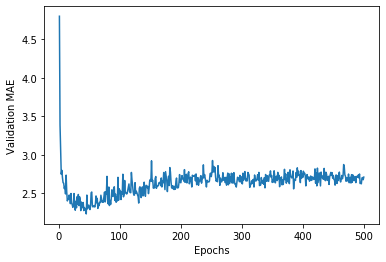

In [22]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Let's get a smoother curve

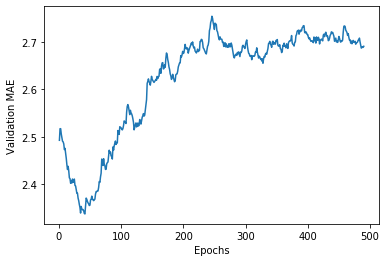

In [24]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Here we can see that the score increases after approximately 50 epochs.  
Now we can get an optimum epochs number, together with adjusting other parameters like the size of the hidden layers.

In [36]:
# let's get the epochs number for the min value of the average MAE
idx = np.argmin(average_mae_history)
idx

44

In [37]:
model = build_model()
model.fit(train_data, train_targets, epochs=44, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 1ms/step


In [38]:
test_mae_score

2.7670136994006587

We are still off by about `$2.770`